In [1]:
import numpy as np
import pandas as pd
import cooler
import bioframe

In [2]:
import cooltools
from cooltools.lib import numutils
from cooltools.sandbox.obs_over_exp_cooler import (
    obs_over_exp,
    obs_over_exp_generator,
    expected_full,
)

In [3]:
from scipy.sparse import coo_matrix
from matplotlib import colors
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# clr = cooler.Cooler("./ALV-repo/Hap1-WT-combined.mcool::/resolutions/500000")
# download test data
# this file is 145 Mb, and may take a few seconds to download
cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir='./')    
print(cool_file)

./test.mcool


In [5]:
# Load a Hi-C map at a 1Mb resolution from a cooler file.
binsize = 1_000_000
clr = cooler.Cooler(f'./test.mcool::/resolutions/{binsize}')

In [6]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
# create a view with chromosome arms using chromosome sizes and definition of centromeres
hg38_arms = bioframe.make_chromarms(hg38_chromsizes,  hg38_cens)
# select only those chromosomes available in cooler
hg38_arms = hg38_arms[hg38_arms.chrom.isin(clr.chromnames)].reset_index(drop=True)
hg38_arms

,chrom,start,end,name
0,chr2,0,93139351,chr2_p
1,chr2,93139351,242193529,chr2_q
2,chr17,0,24714921,chr17_p
3,chr17,24714921,83257441,chr17_q


In [7]:
# calculate full expected (cis + trans)
expected_df = expected_full(
    clr,
    view_df=hg38_arms,
    smooth_cis=False,
    aggregate_trans=True,
    expected_column_name="expected",
    ignore_diags=2,
    chunksize=10_000_000,
    nproc=2,
)

INFO:root:Done calculating cis expected in 0.570 sec ...
INFO:root:Done calculating trans expected in 0.539 sec ...
INFO:root:Returning combined expected DataFrame.


### First, let's do eigendecomp with a combination of sparse OE and dense eigdecomp (as a control)...

In [8]:
# collect obs/exp for chunks of pixel table (in memory for 1Mb cooler)
results = []
for oe_chunk in obs_over_exp_generator(
        clr,
        expected_df,
        view_df=hg38_arms,
        expected_column_name='expected',
        oe_column_name='oe',
        chunksize=1_000_000,
    ):
    results.append(oe_chunk)
# concat chunks into single DataFrame - res_df - is a new pixel table - sparse matrix
res_df = pd.concat(results, ignore_index=True)

In [9]:
# OBS/EXP from sparse (res_df) to dense (oe)
N = len(clr.bins())
oe = coo_matrix(
    (res_df["oe"], (res_df["bin1_id"], res_df["bin2_id"])),
    shape=(N,N),
).toarray()
# make it symmetric ...
oe = oe + oe.T
print(f"generated symmetrix obs/exp matrix of size {N} X {N}")

generated symmetrix obs/exp matrix of size 327 X 327


####  reuse internals of the eigdecomp-function to eigendecompose pre-calculated OE:

In [10]:
# eigendecompose an *entire* OE heatmap (cis+trans), just as an example
n_eigs = 50
ignore_diags = 2
OE = oe.copy()
OE[~np.isfinite(OE)] = 0
mask = OE.sum(axis=0) > 0
if ignore_diags:
    for d in range(-ignore_diags + 1, ignore_diags):
        numutils.set_diag(OE, 0.0, d)

# # subtract 1.0 -> don't have to do it really ...
# OE -= 1.0

# empty invalid rows, so that get_eig can find them
OE[~mask, :] = 0
OE[:, ~mask] = 0

eigvecs, eigvals = numutils.get_eig(OE, n_eigs, mask_zero_rows=True)
eigvecs /= np.sqrt(np.nansum(eigvecs ** 2, axis=1))[:, None]
eigvecs *= np.sqrt(np.abs(eigvals))[:, None]

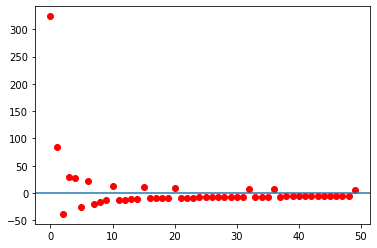

In [11]:
# let's plot sorted eigenvalues
plt.plot(eigvals,"ro")
plt.axhline(0)

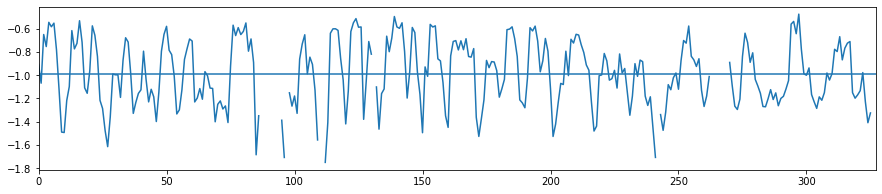

In [12]:
# plot first eigenvector E1
E1 = eigvecs[0]
f = plt.figure(figsize=(15,3))
plt.plot(E1)
plt.axhline(np.nanmean(E1))
plt.gca().set_xlim(0,len(clr.bins()));

##### Let's plot first 4 "components" of eigendecomposition, i.e. lambda_i * np.outer(Ei, Ei)

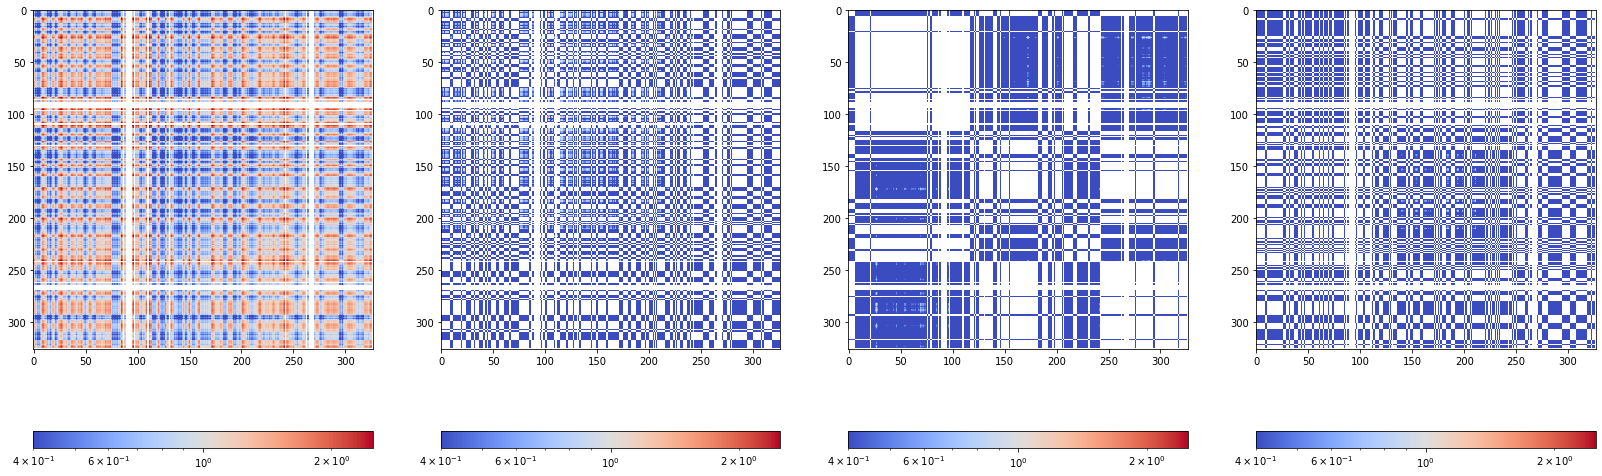

In [13]:
# plot observed and stitched obs/exp side by side
istart, iend = 0, 327

f,axs = plt.subplots(1,4,figsize=(28,10))
for i in range(4):
    eigv = eigvals[i]
    ei = eigvecs[i]
    img = axs[i].imshow(
        np.sign(eigv)*np.outer(ei, ei),
        interpolation="none",
        cmap="coolwarm",
        norm=colors.LogNorm(vmin=0.4,vmax=2.5)
#         norm=colors.Normalize(vmin=-0.5,vmax=0.5)
    )
    plt.colorbar(img,ax=axs[i],orientation="horizontal")

#### Let's plot the sum of the first 4 components of eigendecomposition: Sum[i=1..4] lambda_i * np.outer(Ei, Ei)

In [14]:
N = len(clr.bins())
mat = np.zeros((N,N))
for i,eigv in enumerate(eigvals):
    if i>5:
        break
    ei = eigvecs[i]
    mat += np.sign(eigv)*np.outer(ei, ei)

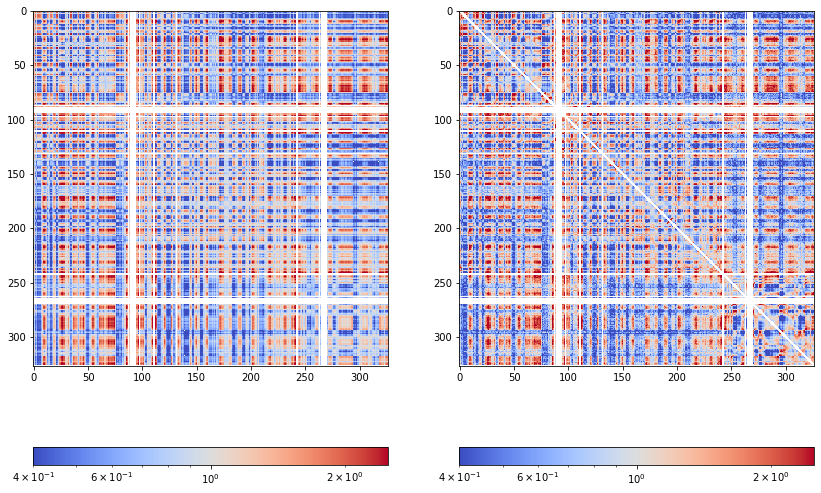

In [15]:
# plot observed and stitched obs/exp side by side
istart, iend = 0, 327
obs = clr.matrix()[istart:iend, istart:iend]
obs_exp = oe[istart:iend, istart:iend]

f,axs = plt.subplots(1,2,figsize=(14,10))
img = axs[0].imshow(
    mat,
    interpolation="none",
    cmap="coolwarm",
    norm=colors.LogNorm(vmin=0.4,vmax=2.5)
)
plt.colorbar(img,ax=axs[0],orientation="horizontal")
img = axs[1].imshow(
    obs_exp,
    interpolation="none",
    cmap="coolwarm",
    norm=colors.LogNorm(vmin=0.4,vmax=2.5)
)
plt.colorbar(img,ax=axs[1],orientation="horizontal")

## Use "streaming" observed over expected for sparse eigendecomposition

In [16]:
from scipy.sparse.linalg import LinearOperator, eigsh
from functools import partial

In [17]:
# Linear Operator that returns matrix/vector product (a vector)
# without explicitly defining that matrix
# this is a helper function to create that Linear Operator :
def oe_matvec(
    vec,  # vector to be multiplied by the OE-matrix
    clr,
    expected_df,
    view_df,
    expected_column_name="expected",
    oe_column_name='oe',
    clr_weight_name='weight',
    chunksize=100_000,
):
    """
    returns an OE_matrix * vec
    OE_matrix is specified as a generator of chunks
    of COO sprase matrix (aka pixel table with OE).
    """
    bad_bin_mask = clr.bins()[clr_weight_name][:].isna().to_numpy()
    # input vec is only for not-masked bins, i.e. reduced size
    # so let's create _vec that has full size len(clr.bins()):
    _vec = np.zeros_like(bad_bin_mask, dtype=float)
    _vec[~bad_bin_mask] = vec
    # where to store the result
    mv = np.zeros_like(bad_bin_mask, dtype=float)
    # consider using bincount with OE weights instead
    oe_streamer = obs_over_exp_generator(
        clr,
        expected_df,
        view_df=view_df,
        expected_column_name=expected_column_name,
        oe_column_name=oe_column_name,
        clr_weight_name=clr_weight_name,
        chunksize=chunksize,
    )
    # OE*vec : sum[j=1..N] OE_ij * vec_j
    for oe_chunk in oe_streamer:
        # also decide how to ignore diags !!!
        bin1_grp = oe_chunk.dropna().groupby("bin1_id")
        bin2_grp = oe_chunk.dropna().groupby("bin2_id")
        for gidx, gdf in bin1_grp:
            _a = _vec[gdf["bin2_id"].to_numpy()]
            _b = gdf["oe"].to_numpy()
            mv[gidx] += np.inner(_a,_b)
            # do np.inner(_a,_b) - np.sum(_a) - to 1-center OE-matrix
        for gidx, gdf in bin2_grp:
            _a = _vec[gdf["bin1_id"].to_numpy()]
            _b = gdf["oe"].to_numpy()
            mv[gidx] += np.inner(_a,_b)
            # do np.inner(_a,_b) - np.sum(_a) - to 1-center OE-matrix
    return mv[~bad_bin_mask]

In [18]:
# turn oe_matvec to 1-argument function f(vector)
f = partial(
    oe_matvec,
    clr=clr,
    expected_df=expected_df,
    view_df=hg38_arms,
    expected_column_name="expected",
    oe_column_name='oe',
    clr_weight_name='weight',
    chunksize=100_000,
)

# finally defining LinearOperator - works on "reduced" vector
# i.e. vector corresponding to "good" bins only:
N = len(clr.bins()) - clr.bins()["weight"][:].isna().sum()
lmv = LinearOperator(
    (N,N),
    matvec = f,
    dtype=float,
)

In [19]:
%%time
# Finally - use LinearOperator in the "eigsh" eigendecomposition:
# right now it takes longer than the "dense"-version,
# but there are more optimizations in the "oe_matvec" to do
eigenvalues, eigenvectors = eigsh(lmv, k=n_eigs)

CPU times: user 47.4 s, sys: 1min 33s, total: 2min 20s
Wall time: 29 s


##### apply same normalizations and reordering as in the eigdecomp ...

In [20]:
order = np.argsort(-np.abs(eigenvalues))
eigenvalues = eigenvalues[order]
eigenvectors = eigenvectors.T[order]
# normalize eigenvector
eigenvectors /= np.sqrt(np.nansum(eigenvectors ** 2, axis=1))[:, None]
eigenvectors *= np.sqrt(np.abs(eigenvalues))[:, None]

In [21]:
# reapply the masking situation ... eigenvectors
evs = np.full_like(
    eigenvectors,
    fill_value=np.nan,
    shape=(eigenvectors.shape[0], len(clr.bins())),
)

_mask = ~clr.bins()[:]["weight"].isna().to_numpy()
evs[:,_mask] = eigenvectors

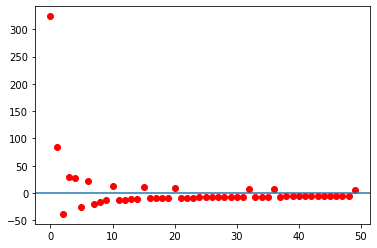

In [22]:
# plot sorted eigenvalues
plt.plot(eigenvalues,"ro")
plt.axhline(0)

(0.0, 327.0)

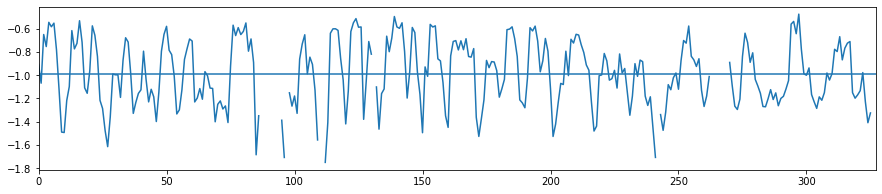

In [23]:
# plot eigenvector E1
E1 = evs[0]
f = plt.figure(figsize=(15,3))
plt.plot(E1)
plt.axhline(np.nanmean(E1))
plt.gca().set_xlim(0,len(clr.bins()))

##### Let's plot first 4 "components" of eigendecomposition, i.e. lambda_i * np.outer(Ei, Ei)

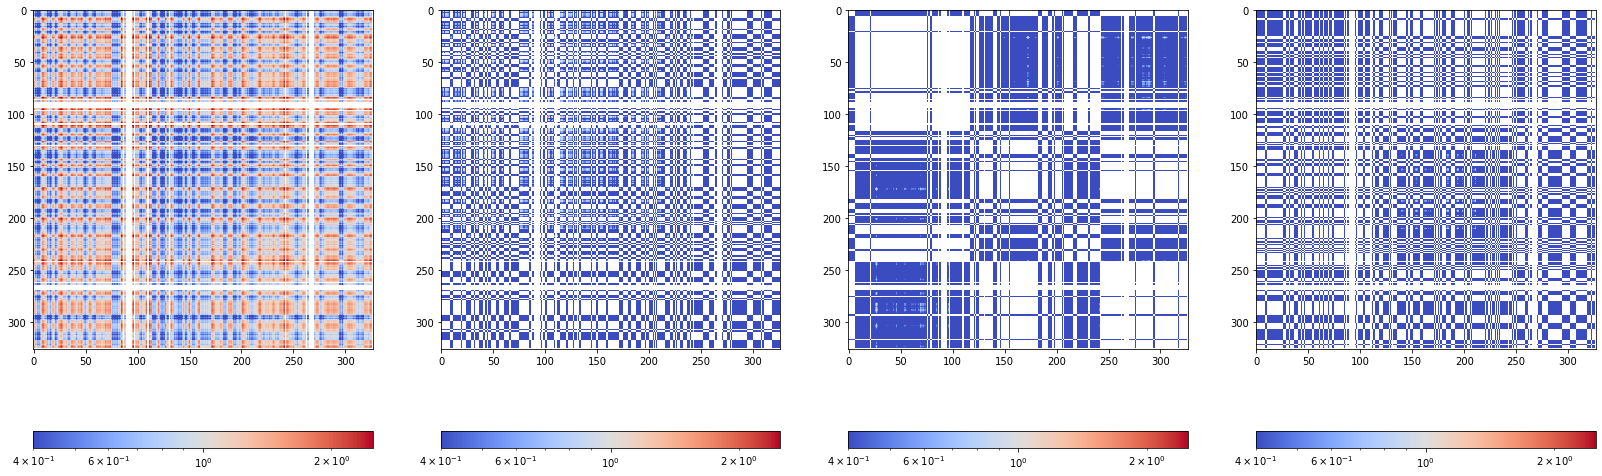

In [24]:
# plot observed and stitched obs/exp side by side
istart, iend = 0, 327

f,axs = plt.subplots(1,4,figsize=(28,10))
for i in range(4):
    eigv = eigenvalues[i]
    ei = evs[i]
    img = axs[i].imshow(
        np.sign(eigv)*np.outer(ei, ei),
        interpolation="none",
        cmap="coolwarm",
        norm=colors.LogNorm(vmin=0.4,vmax=2.5)
    )
    plt.colorbar(img,ax=axs[i],orientation="horizontal")

#### Let's plot the sum of the first 4 components of eigendecomposition: Sum[i=1..4] lambda_i * np.outer(Ei, Ei)

In [25]:
N = len(clr.bins())
mat = np.zeros((N,N))
for i,eigv in enumerate(eigenvalues):
    mat += np.sign(eigv) * np.outer(evs[i], evs[i])

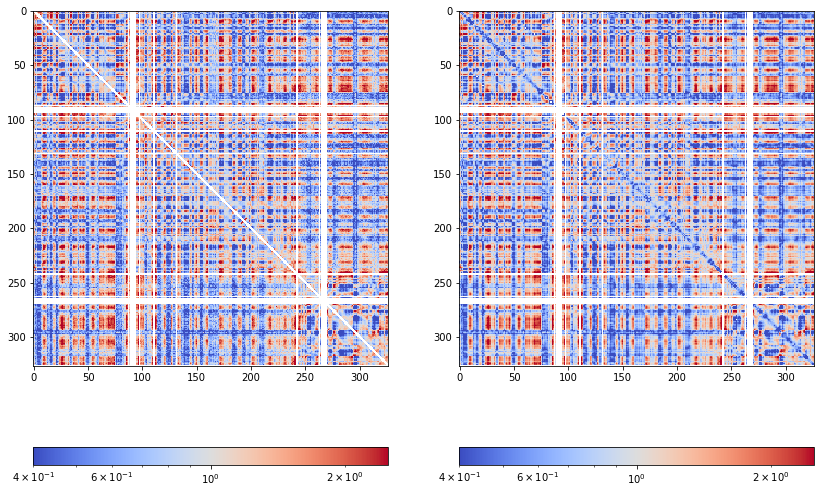

In [26]:
# plot observed and stitched obs/exp side by side
istart, iend = 0, 327
obs = clr.matrix()[istart:iend, istart:iend]
obs_exp = oe[istart:iend, istart:iend]
mmm = mat[istart:iend, istart:iend]

f,axs = plt.subplots(1,2,figsize=(14,10))
img = axs[0].imshow(
    obs_exp,
    interpolation="none",
    cmap="coolwarm",
    norm=colors.LogNorm(vmin=0.4,vmax=2.5)
)
plt.colorbar(img,ax=axs[0],orientation="horizontal")
img = axs[1].imshow(
    mat,
    interpolation="none",
    cmap="coolwarm",
    norm=colors.LogNorm(vmin=0.4,vmax=2.5)
)
plt.colorbar(img,ax=axs[1],orientation="horizontal")

# Testing dask to calculate quantiles of OE - stored as `dd.DataFrame`

In [27]:
import dask
from cooler.sandbox.dask import read_table
from cooltools.sandbox.obs_over_exp_cooler import assign_supports
# use semi-abandoned feature from cooler sandbox
pixels_dd = read_table(f'./test.mcool::/resolutions/{binsize}/pixels', chunksize=10_000)

In [28]:
##############################################################
# we cannot just reuse obs_over_exp_cooler.obs_over_exp_generator here
# because it relies on the clr.pixels()[:] table - but here we are going to
# use the lower level obs_over_exp_cooler.obs_over_exp instead
##############################################################

bins = clr.bins()[:]
bins["r"] = assign_supports(bins, hg38_arms.to_numpy())

pixels_oe = obs_over_exp(
    pixels_dd,
    bins,
    expected_df,
    view_column_name="r",
    expected_column_name="expected",
    clr_weight_name='weight',
    oe_column_name="oe",
)

# calculate several quantiles right away !
pixels_oe["oe"].quantile([0.05,0.25,0.5,0.75,0.95]).compute()

# this seems to work !

0.05    0.409784
0.25    0.672022
0.50    0.935746
0.75    1.367546
0.95    2.374281
Name: oe, dtype: float64